In [ ]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.value, n.grad), shape='record')
        if n.operator:
            dot.node(name=str(id(n)) + n.operator, label=n.operator)
            dot.edge(str(id(n)) + n.operator, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operator)

    return dot

Tensor

In [ ]:
import math

class Tensor:

    def __init__(self, value, label='', children=(), operator=None):
        self.value = value
        self.children = set(children)
        self.operator = operator
        self.grad = 0
        self._backward = lambda: None
        self.label = label

    def __repr__(self) -> str:
        return f"Tensor(value={self.value}, label={self.label})"

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.value * other.value, children=(self, other), operator='*')
        def backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = backward
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.value / other.value, children=(self, other), operator='/')
        def backward():
            self.grad += (1 / other.value) * out.grad
            other.grad -= (self.value / other.value**2) * out.grad
        out._backward = backward
        return out

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.value + other.value, children=(self, other), operator='+')
        def backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = backward
        return out

    def __sub__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.value - other.value, children=(self, other), operator='-')
        def backward():
            self.grad += 1 * out.grad
            other.grad -= 1 * out.grad
        out._backward = backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be an int or float"
        out = Tensor(self.value**other, children=(self,), operator='pow')
        def backward():
            self.grad += (other * self.value**(other - 1)) * out.grad
        out._backward = backward
        return out

    def __exp__(self):
        out = Tensor(math.exp(self.value), children=(self,), operator='exp')
        def backward():
            self.grad += math.exp(self.value) * out.grad
        out._backward = backward
        return out

    def backward(self):
        self.grad = 1
        for tensor in self.topological_sort(self):
            tensor._backward()

    @staticmethod
    def topological_sort(tensor):
        visited = set()
        post_order = []

        def visit(n):
            if n not in visited:
                visited.add(n)
                for child in n.children:
                    visit(child)
                post_order.append(n)

        visit(tensor)
        post_order.reverse()
        return post_order

    def __radd__(self, other):
        return self.__add__(other)

    def __rmul__(self, other):
        return self.__mul__(other)


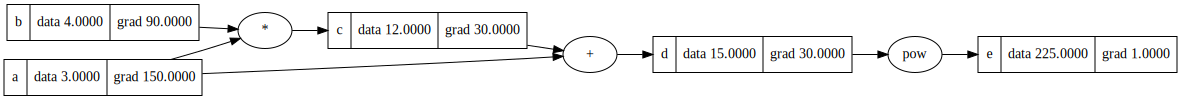

In [ ]:
a = Tensor(3, "a")
b = Tensor(4, "b")
c = a * b; c.label = 'c'
d = a + c; d.label = 'd'
e = pow(d,2); e.label = 'e'

e.backward()

draw_dot(e)

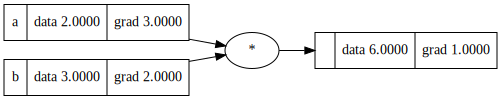

In [ ]:
a = Tensor(2, label='a')
b = Tensor(3, label='b')
c=a*b
# c = a * b; c.label = 'c'
c.backward()
draw_dot(c)
# print(c)

In [ ]:
import math
def tanh (x : Tensor) -> Tensor:
  output_value = (math.exp(x.value) - math.exp(-x.value)) / (math.exp(x.value) + math.exp(-x.value))
  out = Tensor(math.exp(output_value), children=(x,), operator='tanh')
  def backward():
    x.grad = (1 - output_value**2 ) * out.grad
  out._backward = backward
  return out

Neuron

In [ ]:
import random
class Neuron:

  def __init__(self, input_size):
    self.weights = [Tensor(random.random()) for i in range(input_size)]
    self.bias = Tensor(random.random())

  def forward(self, x):
    res = sum([w_i * x_i for w_i, x_i in zip(self.weights, x)])
    res = tanh(res + self.bias)
    return res

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    return self.weights ,self.bias

([Tensor(value=0.2565080866182944, label=), Tensor(value=0.0003039995570904841, label=), Tensor(value=0.3705945087521656, label=)], Tensor(value=0.22723518824834177, label=))


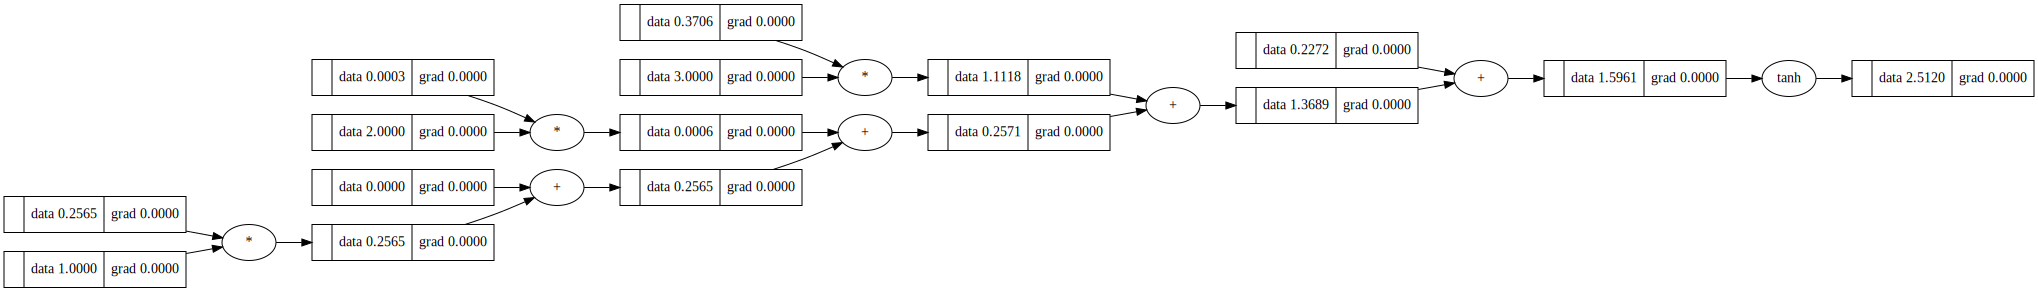

In [ ]:
x = [Tensor(1), Tensor(2), Tensor(3)]
n = Neuron(3)
output = n(x)
print(n.parameters())
draw_dot(output)

Layer

In [ ]:
class Layer:

  def __init__(self, input_size, output_size):
    self.neurons = [Neuron(input_size) for _ in range(output_size)]

  def forward(self, x):
    out = [neuron(x) for neuron in self.neurons]
    return out[0] if len(out)==1 else out

  def __call__(self, x):
    return self.forward(x)

  def parameters(self) :
    bias_list = []
    weight_list = []
    neuron_list = []
    for i in self.neurons :
      bias_list.append(i.bias)
      weight_list.append(i.weights)
      neuron_list.append(i)
    return neuron_list

In [ ]:
x = [1, 2, 1]
l1 = Layer(3, 2)
l2 = Layer(2, 5)
l3 = Layer(5, 1)
output = l3(l2(l1(x)))
draw_dot(output)
for neuron in l2.parameters() :
  print(neuron.parameters())
# print(l2.parameters())

([Tensor(value=0.9537331170070265, label=), Tensor(value=0.016177721487592334, label=)], Tensor(value=0.1629506561780094, label=))
([Tensor(value=0.3711180110972243, label=), Tensor(value=0.48110605319211963, label=)], Tensor(value=0.6775708201154749, label=))
([Tensor(value=0.10341073122751643, label=), Tensor(value=0.15207233863369507, label=)], Tensor(value=0.44830393080930064, label=))
([Tensor(value=0.534180040165686, label=), Tensor(value=0.9406264535532024, label=)], Tensor(value=0.06794074056966681, label=))
([Tensor(value=0.4317222363523038, label=), Tensor(value=0.8554793917904677, label=)], Tensor(value=0.8997339906064217, label=))


MLP

In [ ]:
class MLP:

  def __init__(self, input_size, layer_sizes):
    layers_total = [input_size] + layer_sizes
    self.layers = [Layer(layers_total[i], layers_total[i+1]) for i in range(len(layer_sizes))]

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    para_list = []
    for i in self.layers:
      para_list.append(i.parameters())
    return para_list

In [ ]:
x = [1, 3, 4]
input_size = len(x)
layer_sizes = [2, 3, 1]
model = MLP(input_size, layer_sizes)
output = model(x)

for layers in model.parameters() :
  for neuron in layers :
    print(neuron.parameters())

([Tensor(value=0.14482121586692254, label=), Tensor(value=0.21564808476493802, label=), Tensor(value=0.6048527520177535, label=)], Tensor(value=0.564840667658652, label=))
([Tensor(value=0.008073665912553207, label=), Tensor(value=0.6456026274903779, label=), Tensor(value=0.07584058736084576, label=)], Tensor(value=0.23929292698919413, label=))
([Tensor(value=0.07234258824465056, label=), Tensor(value=0.9724384656464875, label=)], Tensor(value=0.8634776652626047, label=))
([Tensor(value=0.27403268559986416, label=), Tensor(value=0.7101089638732958, label=)], Tensor(value=0.32169568340600774, label=))
([Tensor(value=0.2590835727275298, label=), Tensor(value=0.01905442957046366, label=)], Tensor(value=0.17127723339738665, label=))
([Tensor(value=0.023133485929009545, label=), Tensor(value=0.42331063279966374, label=), Tensor(value=0.9792771074385108, label=)], Tensor(value=0.8870408532614261, label=))


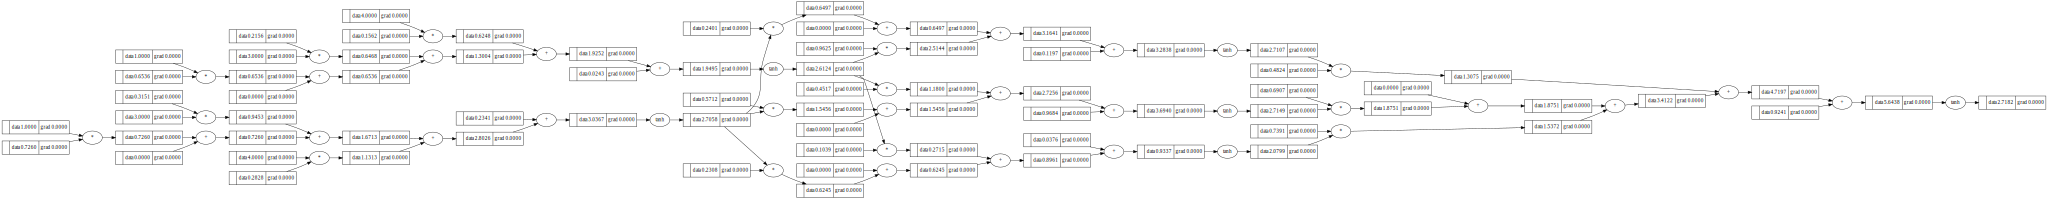

In [ ]:
x = [1, 3, 4]
input_size = len(x) # Number of features in the input layer
layer_sizes = [2, 3, 1] # Number of neurons in each hidden and output layer
model = MLP(input_size, layer_sizes)
output = model(x)
draw_dot(output)

Optimizer

In [ ]:
class Optimizer:
    def __init__(self, parameters, lr):
        # `parameters` expected to be a list of tuples/lists of tensors from the MLP structure
        self.parameters = parameters  # This should be a list of all tensors representing parameters
        self.lr = lr  # Learning rate


    def printpara(self) :
      for layers in self.parameters :
        for neuron in layers :
          print(neuron.parameters())

    def zero_grad(self):
        for layers in self.parameters :
          for neuron in layers :
            for tensor in neuron.weights:
                tensor.grad = 0
                # print(tensor.grad)
            neuron.bias.grad=0



    def step(self):
        # Iterate through all parameter lists (layers) to update each parameter based on its gradient
        for layers in self.parameters :
          for neuron in layers :
            for tensor in neuron.weights:
                tensor.value -= self.lr * tensor.grad
                # print(tensor.grad)
            neuron.bias-=self.lr * neuron.bias.grad



Loss Function

In [ ]:
from typing import List
def MSE(y_hats: List[Tensor], labels: List[Tensor]) -> Tensor:
    if len(y_hats) != len(labels):
        raise ValueError("The lengths of y_hats and labels must match.")

    total_error = Tensor(0,"total_error")
    for y_hat, label in zip(y_hats, labels):
        total_error += (y_hat - label) ** 2

    out= total_error / len(y_hats)

    return out
    # return total_error

In [ ]:
y_hats = [Tensor(2.5), Tensor(0.0), Tensor(1.5)]
labels = [Tensor(3.0), Tensor(-0.5), Tensor(2.0)]
mse_value = MSE(y_hats, labels)
print("MSE:", mse_value)

MSE: Tensor(value=0.25, label=)


In [ ]:
# Assuming MLP initialization

x = [1, 3]
input_size = len(x)
layer_sizes = [2, 1]
model = MLP(input_size, layer_sizes)
output = model(x)
label=[Tensor(2)]

optimizer = Optimizer(parameters=model.parameters(), lr=0.15)
epochs = 900


for i in range(epochs):
  y_hats=[model(x)]
  loss = MSE(y_hats,label)
  optimizer.zero_grad()

  loss.backward()
  optimizer.step()
  print(i)
  print(loss)
  print(y_hats)
  print("******")


draw_dot(y_hats[0])
# draw_dot(loss)

0
Tensor(value=0.5146040512223047, label=)
[Tensor(value=2.717359081090011, label=)]
******
1
Tensor(value=0.5145982770134107, label=)
[Tensor(value=2.7173550564493225, label=)]
******
2
Tensor(value=0.5145924524519644, label=)
[Tensor(value=2.71735099668988, label=)]
******
3
Tensor(value=0.5145865768777814, label=)
[Tensor(value=2.7173469013509304, label=)]
******
4
Tensor(value=0.5145806496190942, label=)
[Tensor(value=2.7173427699636306, label=)]
******
5
Tensor(value=0.5145746699923122, label=)
[Tensor(value=2.717338602050881, label=)]
******
6
Tensor(value=0.5145686373017443, label=)
[Tensor(value=2.717334397127131, label=)]
******
7
Tensor(value=0.514562550839343, label=)
[Tensor(value=2.7173301546981996, label=)]
******
8
Tensor(value=0.5145564098844262, label=)
[Tensor(value=2.7173258742610824, label=)]
******
9
Tensor(value=0.5145502137033898, label=)
[Tensor(value=2.7173215553037493, label=)]
******
10
Tensor(value=0.5145439615494212, label=)
[Tensor(value=2.717317197304945,